# ML for Kids: K-Nearest Neighbors - part I

## Wprowadzenie

Wobrazmy sobie, ze wlasnie dostalismy prace w start-up'ie zajmujacym sie wdrazaniem innowacji w zakresie genetyki roslin. Podczas rozmowy przy kawie z nowo poznanymi wspolpracownikami przychodzi do nas nasz meneder i prosi nas o stworzenie programu do szybkiego klasyfikowania gatunkow irysa. Mowi nam ze zadanie to jest bardzo wazne dla stworzenia automatycznego procesu sortowania wychodowanych kwiatow. Zakasamy wiec rekawy, bierzemy lyk naszej ulubionej kawy i zabieramy sie do pracy

## Sformulowanie problemu

Szef kazal nam zbudowac klasyfikator. Czyli majac informacje o roznych cechach obseracji musimy je przyporzadkowac do danej klasy. Problem klasyfikacji (przypisanie do zmiennej etykiety) oraz regeresji (przewidzenie zmiennej numerycznej - na przyklad do przewidzenia ceny domu) do dwa najpopularniejsze zagadnienia w uczeniu maszynowym z nadzorem. Uczenie maszynowe czyli probujemy nauczyc komputer jakis wzorcow w tym co widzi. Z nadzorem czyli mamy z gory okresolne cechy obserwacji i jakies etykiety. Okej czyli wiemy juz czego od nas oczekuja.

Zanim zabierzemy sie za tworzenie modelu musimy doglebnie poznac nasze dane i zrozumiec zaleznosci panujace miedzy nimi. Zaczynamy wiec ogladac nasze dane z roznych perspektyw - przy uzyciu tabel, metryk, podsumowan oraz przy uzyciu wizualizacji.

Widzimi ze dane ktorymi dysponujemy zawieraja informacje o dlugosci dzialki kielicha, szerokosci dzialki kielicha, dlugosci platka, szerokosci plataka oraz o gatunku irysa. 

In [1]:
import pandas as pd 
import numpy as np

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
iris = pd.read_csv(url, header=None, names=columns)

In [2]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
iris.shape

(150, 5)

In [4]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Widzimy, ze gatunki kwiatow ktore mamy w danych sa 3 - seotsa, versicolor i virginica. Widzimy tez ze kazda obserwacja moze przyjmowac maksymalnie jednen gatunek na raz. 
Jest to tak zwany problem klasyfikacji wieloklasowej (mamy wiele klas ale kazda obserwacja moze miec jedna klase). Podobnie jest gdy na 
Inne mozliwosci klasyfikacji to klasyfikacja binarna (mamy 2 klasy i kazda obseracja moze przyjmowac jedna kalse). Przydaje sie w identyfikacji czy mail jest spamem czy nie.
Oraz problem klasyfikacji wieloetykietowej (mamy wiele klas i kazda obserwacja moze na raz przyjmowac wiele klas). Uzyteczne gdy autonomiczne auto musi zidentyfikowac wiele obiektow na klatce z kamery - ludzi, znaki, inne auta, droge, sygnalizacje itp.

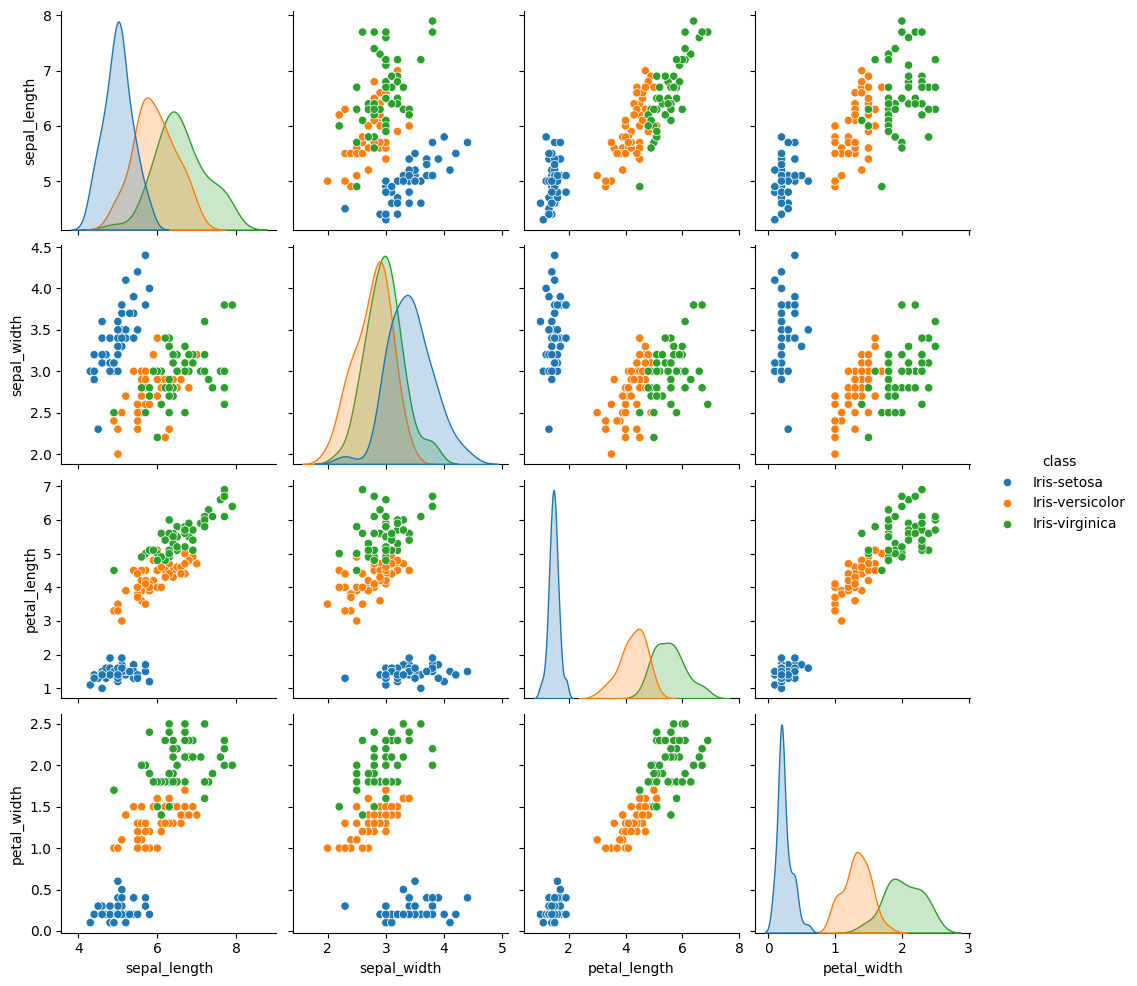

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(iris, hue="class", diag_kind="kde")
plt.show()

Na podstawie powyzszych wizualizacji, zauwazamy ze gatunki kwiator sa dosc dobrze odseparowane biorac pod uwage dowolne dwie cechy. Dodatkowo widzimy ze obserwacje wystepuja blisko siebie, w zwartych grupach.
Wnioskujemy ze obserwacje znajdujace sie blisko siebie sa podobne - to znaczy na podstawie podobnych da sie okreslic ze naleza do podobnych gatunkow.

Rodzi nam sie w glowie pomysl, czemu by nie uzyc tej wlasnosci i zbudowac klasyfikator ktory by przypisywal nowe obserwacji do grup do ktorych ma podobne cechy. Jest to duzy krok w przod. 

Jednak napotykamy pierweszy problem. Jak do kocna wiemy co to znaczy ze obserwacje sa podobne. Widzimy to na wizualizacji ale nie do konca umiemy wytlumaczyc czemu. Potrzebujemy wiec odpowiedniego narzedza by powiedziec ze dowolne dwie obserwacje sa do siebie podobne...

## Definicja podobienstwa

Po chwili namyslu wpada nam nowy pomysl do glowy. Przeciez mamy cechy numeryczne. Mozemy odjac od siebie wartosci cech dwoch roznych obserwacji, a dystans miedzy nimi bedzie nam mowic jak "silne" jest podobienstwo (niski wynik -> silne podobienstwo, wysoki wynik -> slabe podobienstwo).

Zaczynamy wiec nasze pierwsze eksperymenty, na poczatku z dowolna pojedyncza cecha...

(uzyj analogi z miastami)

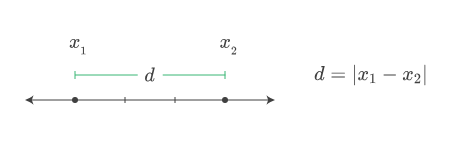

In [9]:
iris.petal_length[0], iris.petal_length[2]

(np.float64(1.4), np.float64(1.3))

In [10]:
iris.petal_length[0] - iris.petal_length[2]

np.float64(0.09999999999999987)

In [12]:
iris.petal_length[2] - iris.petal_length[0]

np.float64(-0.09999999999999987)

Zauwazamy diwe niescislosci z ktorymi bedziemy musieli sobie poradzic.
Pierwsza to skoro sprawdzamy jak punkty A i B sa od siebie oddalone, to dystans miedzy punktem A i B oraz miedzy punktem B i A musi byc taki sam - cecha ta nazywa sie symetria: $d(x, y) = d(y, x)$.
Dodatkowo skoro sprawdzamy jak punkty A i B sa od siebie oddalone, to dystans ten przeciez nie moze byc mniejszy od zera - cecha ta to nieujemnosc $d(x,y) \geq 0$.
Bedziemy wiec dalej uzywac wartosci bezwzglednej.

In [14]:
iris.petal_length[0] - iris.petal_length[0]

np.float64(0.0)

Zauwazamy druga ceche. Dystanst  punktu do siebie powinien byc rowny zero, po ten sam punkt jest przeciez w jednym i tym samym miejscu - cecha ta to tozsamosc nieodroznialnych: $d(x,y) \iff x=y$

Ostatnia ceche troche ciezej znalezc dlatego uzywamy googl'a - w koncu pracujemy w it.

In [18]:
np.abs(iris.petal_length[0] - iris.petal_length[2])

np.float64(0.09999999999999987)

In [19]:
np.abs(iris.petal_length[2] - iris.petal_length[3])

np.float64(0.19999999999999996)

In [20]:
np.abs(iris.petal_length[0] - iris.petal_length[3])

np.float64(0.10000000000000009)

Zauwazamy ze przeciez... czyli najkrótsza droga między dwoma punktami to zawsze prosta linia, a każda droga „naokoło” jest dłuższa lub równa - cecha ta to nierownosc trojkata: $d(x,z) \leq d(x,y) + d(y,z)$

Super udalo nam sie poprawnie zdefiniowac dystans, czyli funkcje ktora pomoze nam w powiedzeniu jak bardzo dwa punkty sa od siebie rozne, o cechach
- Nieujemność
- Tożsamość nieodróżnialnych
- Symetria
- Nierówność trójkąta

Narazie sprawdzilismy dystans pomiedzy ta sama cecha dla roznych obseracji, ale co gdyby rozszerzyc to do dwoch cech...
Nie wiemy co zrobic, wiec zaczynamy korzystac z narzedzi ktore posiadamy, bo zauwazamy ze przeciez dystans mozemy policzyc osobno dla cechy A i dla cechy B.
Rozbijamy wiec problem na mniejsze podproblemy i liczymy dwie miary. Nastepnie korzystamy z twierdzenie pitagorasa by skondensowac nasze dwie wartosci w jedną.

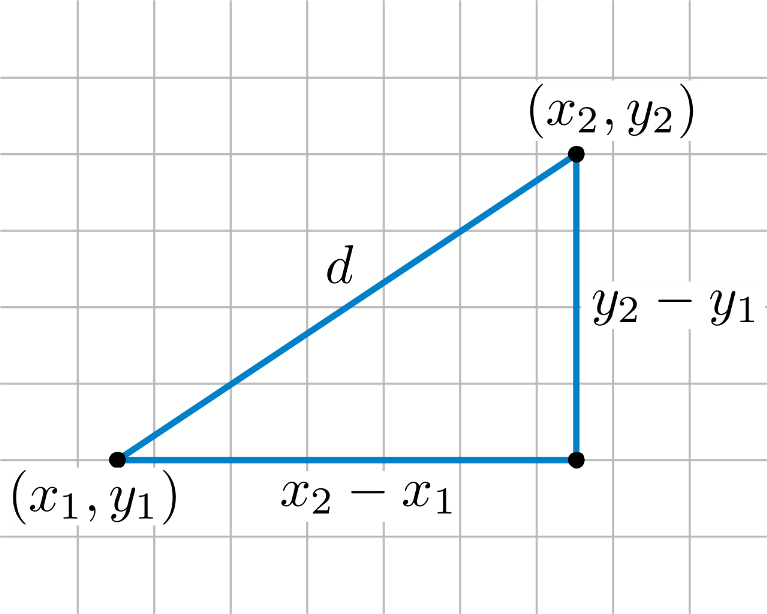

Swietnie czyli juz wiemy co zrobic gdy mamy dwie cechy

![dIz (a, b) =.jpg](<attachment:dIz (a, b) =.jpg>)

Po chwili namyslu dochodzimy do wniosku ze w 3 wymiarach przeciez tez skorzystamy z tej samej zasady.

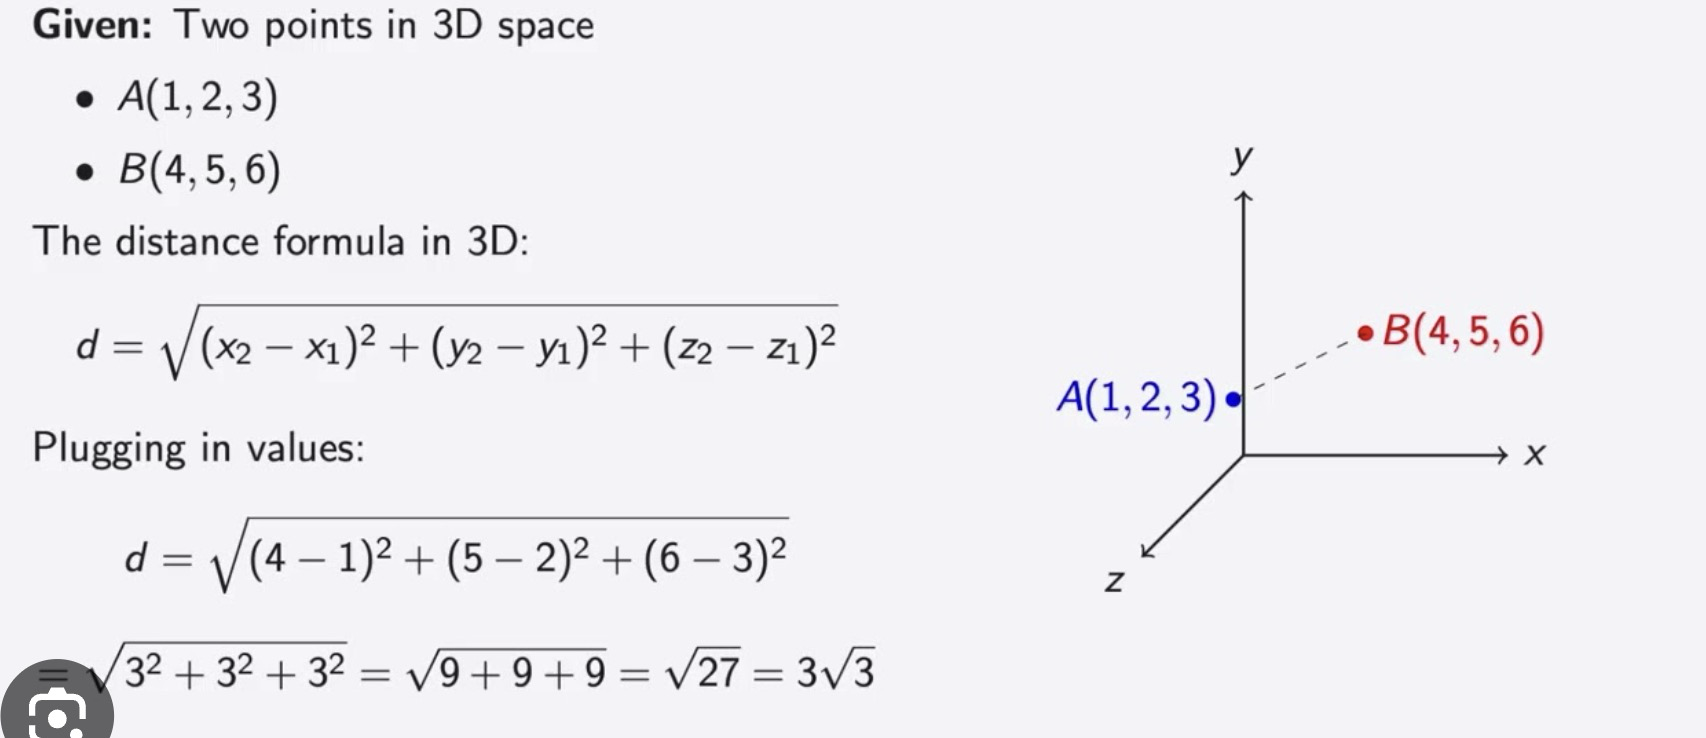

Uogolniamy wiec nasze "odkrycia" i dostajemy wzor: $d = \sqrt{\sum_i (a_i - b_i)^2}$

Genialnie odkryslimy wlasnie norme L2 ale tak w sumie to norme L1 tez odkylismy po drodze, bo rowna sie ona: $d_{L1}=\sum_i |a_i-b_i|$

I mozemy tak wymienia w nieskonczonosc bo norm L jest az $n$...

Glowne roznice miedzy nimi to jak traktuja przestrzen po ktorej sie poruszamy...

* L1 traktuje wszystkie wymiary równomiernie i sumuje je liniowo, Tak jakbyś musiał przejść po chodniku wzdłuż ulic: najpierw krok w prawo, potem krok w górę
* L2 mocniej karze duże odchylenia w jednym wymiarze (bo podnosimy do kwadratu), Idziesz na skróty po przekątnej, czyli najkrótszą możliwą drogą
* L∞ ignoruje wszystkie mniejsze różnice i patrzy tylko na największą Liczy się tylko największy krok w którymś kierunku


![The number of non-zero.jpg](<attachment:The number of non-zero.jpg>)
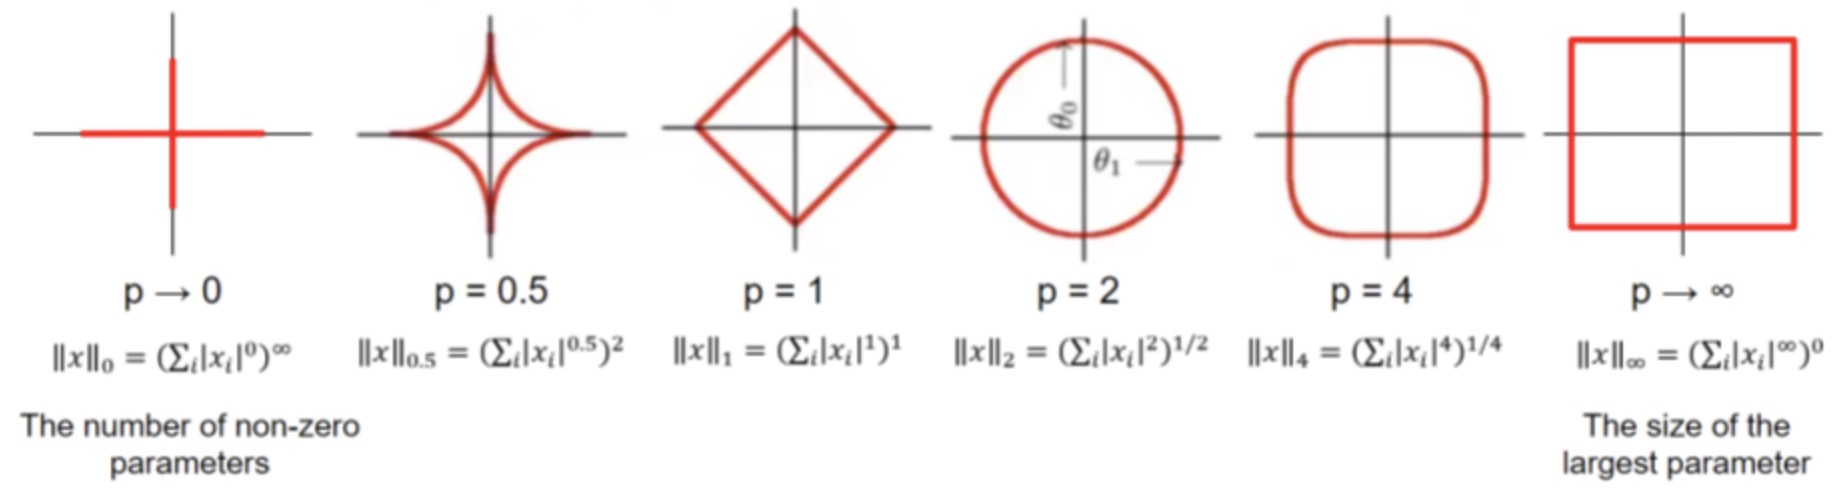

Ale nie jest to przeciez jedyny sposob policzenia dystansy dla cech numerycznych. Poza norma L istnieja tez miary np. Mahalanobis, Cosine distance, Bray–Curtis. I kazda jest przydatna w jakims specyficznym zadaniu.
Np miary cosinusowje uzywa sie do porwnania podobienstwa miedzy slowami (a dokladnie to miedzy wektorami zanurzen ich tokenow ale to temat na inna rozmowe)

Dla cech kategoryczych rowniez mozemy obliczyc dystas, choc jest to duzo mniej popularne i sensowne - bo jak jest odleglsoc miedzy koszulka o kolorze czerwonym i zielonym, albo miedzy koszulka rozmiar m i rozmiar l i czy bedzie taka sama jak miedzy rozmiarem s i m. Ale jedna z popularniszych miar jest miara jest Humming distance. Mamy rozne cechy dla dowch obseracji i po prostu zliczamy pozycje na ktorych cechy dwoch obseracji sa inne i sumujemy to. Poza tym mamy tez Jaccard distance, Simple matching coefficiene i tutaj podobnie każda jest przystosowana do specyficznego problemu.


## Podsumowanie

Podczas tej sesji pracy odkrylismy ze... (podsumowanie)

Świetnie skoro już wiemy, jak policzyć podobieństwo miedzy obserwacjami to po ktorkiej przerwie na kawe bedziemy mogli sie wziac za napiszmy kodu implementujący ten nasz algorytm klasyfikujacy

# ML for Kids: K-Nearest Neighbors - part II

## Wprowadzenie

Poprzednio dostalismy zadanie stworzenia klasyfikatora gatunkow kwaitow. Przeprowadzilismy wstepna analize danych po ktorych zdecydowalismy ze dobrym pomyslem moze byc stworzenie algorytmu klasyfikujacego obserwacje o podobncyh cechach do podobnych grup.
Aby to zrobic zdefiniowalismy czym jest dystanst, czyli narzedzie ktorego uzyjemy do mierzenia podobienstwa miedzy obserwacjami.

Po lyku kawy mozemy sie zabierac do stworzenia pierwszej wersji naszego klasyfikatora, ktory bedzie brac pod dwie cechy obserwacji.

## WEKTORYZACJA

## CURSE OF DIMENSIALITY

# ML for Kids: K-Nearest Neighbors - part III

## MIARY OCENY